In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib
import os
import json
from sklearn.model_selection import GridSearchCV
import gc
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [20]:
#Loading datasets with memory optimization

def reduce_memory_usage(df):
    """Reduce memory usage of DataFrame"""
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].ast(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization: {end_mem:.2f} MB")
    print(f"Reduced by {100 * (start_mem - end_mem) / start_mem:.1f}%")
    
    return df

train_df = reduce_memory_usage(pd.read_csv('../data/processed/train.csv'))
val_df = reduce_memory_usage(pd.read_csv('../data/processed/val.csv'))
test_df = reduce_memory_usage(pd.read_csv('../data/processed/test.csv'))

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Initial memory usage: 454.37 MB
Memory usage after optimization: 223.13 MB
Reduced by 50.9%
Initial memory usage: 56.77 MB
Memory usage after optimization: 27.88 MB
Reduced by 50.9%
Initial memory usage: 56.78 MB
Memory usage after optimization: 27.88 MB
Reduced by 50.9%
Train shape: (4253927, 14)
Validation shape: (531537, 14)
Test shape: (531559, 14)


In [21]:
SAMPLE_SIZE = 50000  #adjusting based on memory cap
if len(train_df) > SAMPLE_SIZE:
    print(f"Sampling {SAMPLE_SIZE} records for training")
    train_df = train_df.sample(SAMPLE_SIZE, random_state=42)
    val_df = val_df.sample(min(SAMPLE_SIZE//5, len(val_df)), random_state=42)
    test_df = test_df.sample(min(SAMPLE_SIZE//5, len(test_df)), random_state=42)

train_df = reduce_memory_usage(train_df)
val_df = reduce_memory_usage(val_df)
test_df = reduce_memory_usage(test_df)

Sampling 50000 records for training
Initial memory usage: 3.00 MB
Memory usage after optimization: 3.00 MB
Reduced by 0.0%
Initial memory usage: 0.60 MB
Memory usage after optimization: 0.60 MB
Reduced by 0.0%
Initial memory usage: 0.60 MB
Memory usage after optimization: 0.60 MB
Reduced by 0.0%


In [22]:
le = LabelEncoder()
train_df['route_encoded'] = le.fit_transform(train_df['route_short_name'].astype(str))
val_df['route_encoded'] = le.transform(val_df['route_short_name'].astype(str))
test_df['route_encoded'] = le.transform(test_df['route_short_name'].astype(str))

#saving the encodder
joblib.dump(le, '../backend/models/route_label_encoder.pkl')

feature_columns = [
    'route_encoded', 'stop_sequence', 'day_of_week', 
    'hour_of_day', 'holiday_flag', 'stop_lat', 'stop_lon'
]

X_train = train_df[feature_columns].copy()
y_train = train_df['delay_minutes'].copy()

X_val = val_df[feature_columns].copy()
y_val = val_df['delay_minutes'].copy()

X_test = test_df[feature_columns].copy()
y_test = test_df['delay_minutes'].copy()

print(f"Feature shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Feature shapes - Train: (50000, 7), Val: (10000, 7), Test: (10000, 7)


In [23]:
#random forest training

rf_model = RandomForestRegressor(
    n_estimators=30,           
    max_depth=10,           
    min_samples_split=5,
    min_samples_leaf=2, 
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)
print("Random Forest training completed!")

y_val_pred_rf = rf_model.predict(X_val)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R2: {r2_rf:.2f}")

Random Forest training completed!
Random Forest - MAE: 7.47, MSE: 74.61, R2: -0.00


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished


In [24]:
#xgboost

xgb_model = xgb.XGBRegressor(
    n_estimators=50,         
    learning_rate=0.1, 
    max_depth=6,               
    subsample=0.8,             
    colsample_bytree=0.8,      
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

xgb_model.fit(X_train, y_train)
print("XGBoost training completed!")

y_val_pred_xgb = xgb_model.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
r2_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"XGBoost - MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f}")

XGBoost training completed!
XGBoost - MAE: 7.47, MSE: 74.65, R2: -0.00


In [26]:
#comparing
if mae_rf < mae_xgb:
    best_model = rf_model
    best_model_name = "RandomForest"
    print("Selected Random Forest as the best model")
else:
    best_model = xgb_model
    best_model_name = "XGBoost"
    print("Selected XGBoost as the best model")

# Evaluate on test set
y_test_pred = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Best model ({best_model_name}) on Test set - MAE: {mae_test:.2f}, MSE: {mse_test:.2f}, R2: {r2_test:.2f}")

Selected Random Forest as the best model
Best model (RandomForest) on Test set - MAE: 7.56, MSE: 75.99, R2: -0.00


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.0s finished


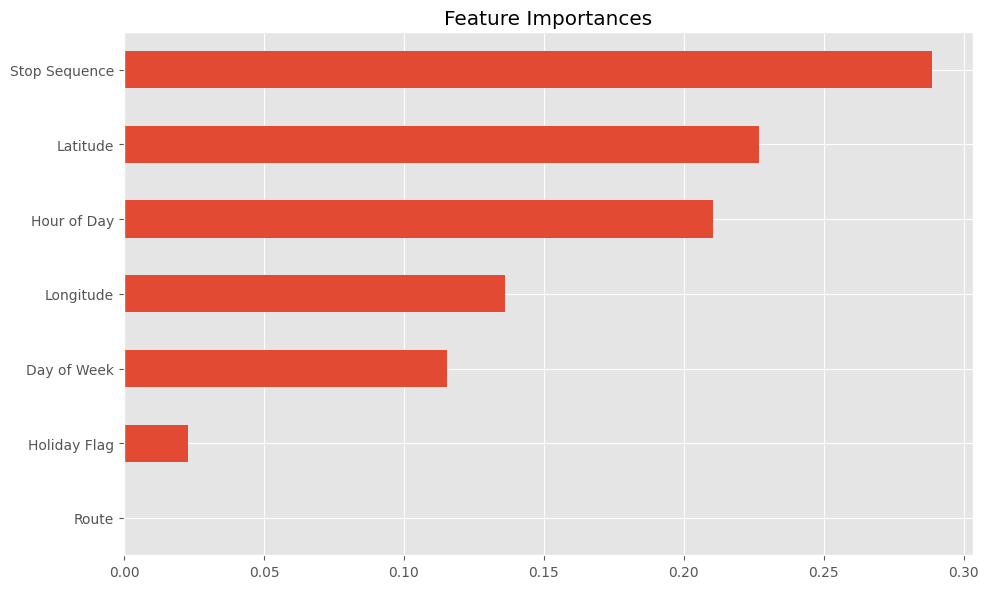

In [27]:
plt.figure(figsize=(10, 6))
feature_importance = best_model.feature_importances_
feature_names = ['Route', 'Stop Sequence', 'Day of Week', 'Hour of Day', 
                 'Holiday Flag', 'Latitude', 'Longitude']

importance_series = pd.Series(feature_importance, index=feature_names)
importance_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importances')
plt.tight_layout()
plt.savefig('../notebooks/feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

In [28]:
#saving training model
model_path = '../backend/models/trained_model.pkl'
joblib.dump(best_model, model_path)

model_metadata = {
    'model_type': best_model_name,
    'feature_columns': feature_columns,
    'feature_names': feature_names,
    'label_encoder_classes': le.classes_.tolist(),
    'performance': {
        'test_mae': mae_test,
        'test_mse': mse_test,
        'test_r2': r2_test
    }
}

with open('../backend/models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print(f"Model saved to {model_path}")

Model saved to ../backend/models/trained_model.pkl
